# Deep Q-Learning DQN

 In this homework we will implement DQN for frozn lake environment

##Frozen lake

Frozen lake is a toy text environment involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. <br>

We can also set the lake to be slippery so that the agent does not always move in the intended direction. But here, we will only look at the non-slippery case.

Documentation for the environment can be found [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

![Frozen Lake](https://gymnasium.farama.org/_images/frozen_lake.gif)

##Q-Learning >< Deep Q-Learning.
Following short theory is based on
[Hugging Face](https://huggingface.co/learn/deep-rl-course/unit3/from-q-to-dqn).

Remember in the general setting of Q-Learning we estimate our action-value function which tells us given a state which action should we take. From this we can create the Q-table to overview all possible combinations of states and actions.

Mainly for problems where the state space grow unmanageble big creating updating a Q-table for that environment could be a tedious task. What we can do instead is approximate the Q-values using a parametrized function $Q_\theta(s,a)$ which we in this case learn from a neural network.

This neural network will approximate, given a state, the different Q-values for each possible action at that state.

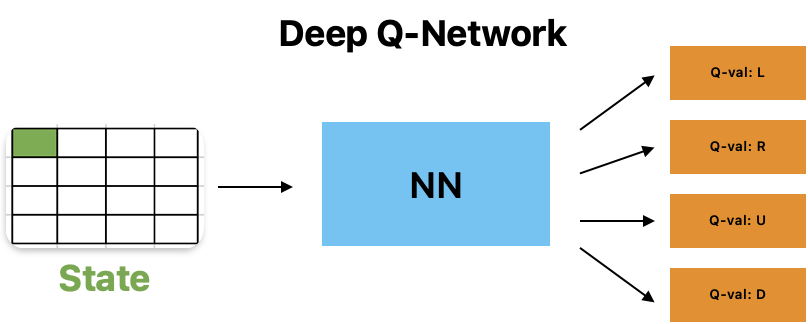

With regular Q-learning we would update the Q-value for a (*state*, *action*)-pair as following:
$$Q(s_t, a_t) \leftarrow \underset{(i)}{Q(s_t, a_t)}  + \alpha \left[\underbrace{R_{t+1} + \gamma \: \max_a \{Q(s_{t+1}, a)\}}_{(iii)} - \underset{(ii)}{Q(s_t, a_t)}\right],$$
But in **DQL** we consider the parts
- $(i), (ii)$ is former $Q$-value estimation (i.e. already known),
- $(iii)$ becomes our estimation target in deep Q-learning. We compare this value prediction to the former value to $(ii)$ as a loss function and thus have a object to use gradient descent on to learn weights in the deep Q-network.

## DQL Algorithm

The Deep Q-Learning (DQN) training algorithm consists primarily of these two phases:
1. Sampling: perform actions and store experience in a *replay memory*.
2. Training: Select a random subset (small batch) of *replay memory* and use it to learn using gradient descent.

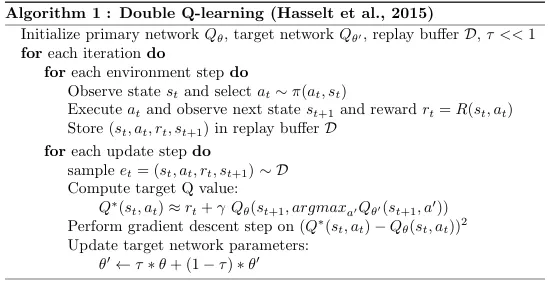

The method of Deep Q-Learning consists of non-linear function approximation (using NN) of the Q-value and a bootstrapping step, where we update targets with existing estimates and not the actual complete return that value would reflect. Both of these methods could introduce instabilities which we try to deal with in following manner:
1. **Experience Replay**: we save experience in Replay Buffer to save experience samples. This makes a more efficient use of actions/experience and allows agent to learn from the same experience multiple times. Further, it helps to avoid forgetting previous experiences.

2. **Fixed Q-target to stabilize training**: we seperate the NN used to estimate the Q-target to use fixed parameters. We update these parameters from the DQN we use for the Q-estimation every *C* steps.

3. **Double DQNs**: we use two networks to decouple action selection from target Q-value generation.


# Implementation

Below the full DQN algorithm is implemented to learn the Frozen lake environment.

## setup

load libs and dependencies

In [1]:
import numpy as np
import gym
import random
import math
from collections import namedtuple

# for plotting
import matplotlib.pyplot as plt
import matplotlib

# PyTorch libs
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
from torch.nn import functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
%matplotlib inline

In [2]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False)

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


##Replay Memory

Make use of experience replay memory. It stores transitions observed by the agent. By sampling from this randomly we can "de"-correlate the transistions that make up a batch.



In [3]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, memSize):
        self.memSize = memSize
        self.memory = []
        self.position = 0

    def push(self, *args):
        """
        Method to save a transition / experience (namedtuple object) to memory buffer
        """
        if len(self.memory) < self.memSize:
          # to create a new place for data to come
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.memSize

    def sample(self, batch_size):
      """
      Method to select a random batch of transistions / experience for training.
      Input:    bacth_size (how many examples)
      Returns:  random batch from buffer
      """
      return random.sample(self.memory, batch_size)

    def __len__(self):
      """
      Method to count elements stored in memory buffer,
      """
      return len(self.memory)

##Q-Network

We implement a simple feed-forward neural network that takes the difference between the current and previous action.

It has four outputs each representing the Q-values for all actions in the given state:
$$Q(s, \text{left}), \quad Q(s, \text{right}),\quad  Q(s, \text{up}), \quad Q(s, \text{down}).$$

We will thus use the NN to predict the expected return of taking each action given the current input (state $s$).

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # takes input dim from states
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        # output dims from actions, one for each possible action
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #print(x.size())
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

##Hyperparameters

In [5]:
# We specify the hyperparameters

total_episodes = 10000       # Total training episodes
max_steps = 300              # Max steps per episode
learning_rate = 1e-3         # Learning rate|
gamma = 0.9                  # Discounting rate
batch_size = 128             # Training Batch size
target_update = 5            # Target network update frequency
train_frquency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1                   # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.001/3            # Exponential decay rate for exploration prob

In [6]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

nspace = env.observation_space.n #in this env this is float
naction = env.action_space.n #discrete case
print('(state, action)-space:', (nspace, naction))


observation space: Discrete(16)
action space: Discrete(4)
(state, action)-space: (16, 4)


We initialize the different objects to use. Note 2 NN: one for target, one for policy estimation

In [7]:
#important part of DQN architecture: 2 DQN - one for target, one for estimation
policy_net = DQN(nspace, naction).to(device)
target_net = DQN(nspace, naction).to(device)

target_net.load_state_dict(policy_net.state_dict())
# this NN will not need any training/optim
# since we will use weights learned from other
target_net.eval()

# this might be better in DQN than ADAM...
opt = optim.RMSprop(policy_net.parameters(), lr = learning_rate)

# memory buffer
mem = ReplayMemory(memSize=10000)


We use an $\varepsilon$-greedy heuristics strategy to balance between exploration vs. exploitation. We decrease $\varepsilon$ from the initial value of `max_epsilon`
decreasing until `min_epsilon` with the rate `decay_rate`.

$$\pi(a|s) = \begin{cases}1-\varepsilon, \quad a = \text{argmax}_a Q_t(s,a) \\ \varepsilon/|A|, \quad a \neq  \text{argmax}_a Q_t(s,a) \end{cases}$$

In [8]:
def get_action(state, epsilon):
  """
  Function for exploration vs. exploitation
  """
  exp_exp_tradeoff = random.uniform(0, 1)
  if exp_exp_tradeoff > epsilon:
    #exploitation - use best action for given state
    with torch.no_grad():
      # want action
      action = policy_net(state).max(1)[1].view(1,1)

  else:
    #exploration - we just sample a random action
    action = env.action_space.sample()
    action = torch.tensor([action], device = device).view(1,1)

  return action

In [9]:
#for plotting
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Training steps pr. episode')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

##Training


Episode 10000: Reward = 1.0, Epsilon = 0.04531725341377989
Complete


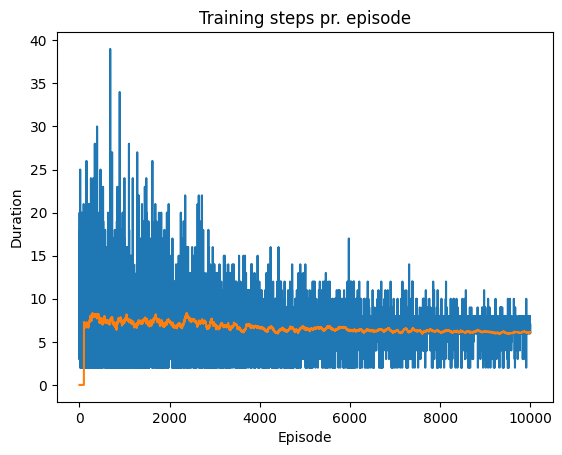

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
# list of steps taken pr episode
episode_durations = []

# List of rewards
rewards = []

for episode in range(1, total_episodes+1):
    # Initialize the environment and state
    state = env.reset()

    # to one-hot
    state_one_hot = torch.zeros(1,nspace)
    state_one_hot[0][state] = 1
    state = state_one_hot.to(device)  # Convert to one-hot and move to device

    total_rewards = 0
    for i in range(max_steps):
        # Select and perform an action
        action = get_action(state, epsilon)
        next_state, reward, done, _ = env.step(action.item())

        total_rewards += reward

        reward = torch.tensor([reward], device=device)
        done = torch.tensor([int(done)], device=device)

        # to one-hot
        next_state_one_hot = torch.zeros(1,nspace)
        next_state_one_hot[0][next_state] = 1
        next_state = next_state_one_hot.to(device)  # Convert to one-hot and move to device

        # Store the transition in memory
        mem.push(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state_one_hot

        if done:
          episode_durations.append(i + 1)
          plot_durations()
          break

    # optimize the policy
    if episode % train_frquency == 0 and len(mem) >= batch_size:
      for _ in range(train_epochs):
        # get samples from experience replay memory
        transitions = mem.sample(batch_size)

        # unroll and reroll to get them in proper format
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states and get the max q values.
        with torch.no_grad():
          next_state_values = target_net(next_state_batch).max(1)[0].detach()
        # Compute the target Q values
        target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

        # Optimize the model
        opt.zero_grad()
        loss.backward()
        opt.step()


    # Update the target network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    rewards.append(total_rewards)
    print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


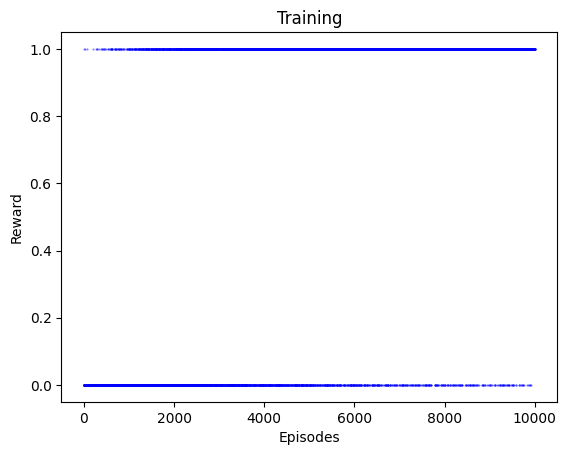

In [11]:
# plotting training rewards
plt.plot(rewards, 'bo', markersize=.5, alpha=.5)
#plt.axhline(y=np.mean(rewards), color='r', linestyle='dashed', label='mean')
plt.title('Training')
#plt.legend(fontsize="8", loc='upper left')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

## Testing

In [39]:
test_episodes = 100
# test
test_wins=[]
for episode in range(test_episodes):
    state = env.reset()

    # one hot encoding
    state_one_hot = torch.zeros(1,nspace)
    state_one_hot[0][state] = 1
    state = state_one_hot.to(device)

    done = False
    reward=0

    for t in range(max_steps):
        action = get_action(state, epsilon)
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor([next_state], device=device)

        # convert to one hot encoding
        next_state_one_hot = torch.zeros(1,nspace)
        next_state_one_hot[0][next_state] = 1
        next_state = next_state_one_hot.to(device)

        state = next_state_one_hot
        if done:
            break

    test_wins.append(reward)
env.close()

print('---- Test Episodes ',test_episodes, ' ----',
      '\n --- Avg. success = ', int(100*np.mean(test_wins)), '% ---')

---- Test Episodes  100  ---- 
 --- Avg. success =  100 % ---


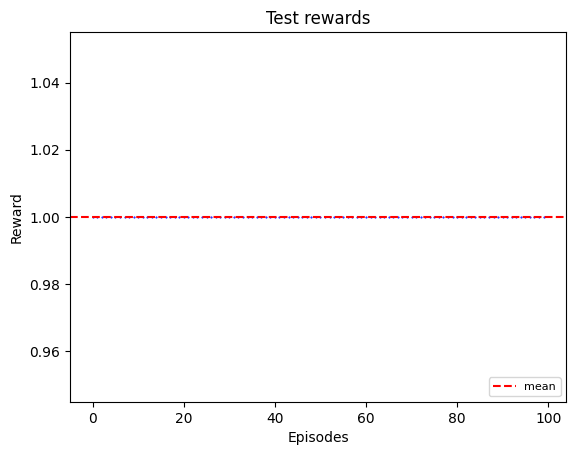

In [40]:
# plotting test rewards
plt.plot(test_wins, 'bo', markersize=.5)
plt.axhline(y=np.mean(test_wins), color='r', linestyle='dashed', label='mean')
plt.title('Test rewards')
plt.legend(fontsize="8", loc='lower right')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

#Visualizing

We visualize our method to make sure our learning is as intended.

In [14]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [15]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    state_one_hot = torch.zeros(1,nspace)
    state_one_hot[0][state] = 1
    state = state_one_hot.to(device)  # Convert to one-hot and move to device

    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action = get_action(state, epsilon)
        next_state, reward, done, info = env.step(action.item())
        next_state = torch.tensor([next_state], device=device)
        next_state_one_hot = torch.zeros(1,nspace)
        next_state_one_hot[0][next_state] = 1
        next_state = next_state_one_hot.to(device)  # Convert to one-hot and move to device
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state_one_hot
        if done:
            break
    vid.close()
    env.close()

In [45]:
show_video_of_model("FrozenLake-v1")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment FrozenLake-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [46]:
show_video("FrozenLake-v1")